# Eddy Detector

Term project for ESS 490/590

Grad: Erik Fredrickson

Undergrad: Ashika Capirala

*Some kind of project description can go here*

put a reminder here about the dependencies, and include an example line of how to load the environment file (should be included in our directory)

In [1]:
# imports (WILL NEED TO BE UPDATED AS WE GO!)
import random
from math import cos, sin, pi, sqrt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# keep these
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc

# Import the Obspy modules that will be useful to download IRIS data
import obspy
import obspy.clients.fdsn.client as fdsn
from obspy import UTCDateTime

## Import Data

### APG pressures (and temperatures)

Get bottom temperature and bottom pressure from IRIS (https://www.iris.edu/hq/)

In [ ]:
# Pull pressure and temperature data from IRIS
network = 'XO'
staNames = ['LA21', 'LA34', 'LA33', 'LA23', 'LA25', 'LA22', 'LA28', 'LA39', 'LA32', 'LA30', 'LT07', 'LT06', \
           'LT13', 'LT03', 'LT11', 'LT04', 'LT01', 'LT20', 'LT14', 'LT16', 'LT10', 'LT12']
staCodes = 'LA21,LA34,LA33,LA23,LA25,LA22,LA28,LA39,LA32,LA30,LT07,LT06,LT13,LT03,LT11,LT04,LT01,LT20,LT14,LT16,LT10,LT12'
chaNames = ['HDH', 'HKO']
chaCodes='HDH,HKO'
Tstart = UTCDateTime(2018, 06, 01)
Tend = UTCDateTime(2019, 06, 20)

fdsn_client = fdsn.Client('IRIS')

# DO NOT RUN AS WRITTEN -- way too much data, so we'll need to make a loop to parse it by station and by day
Dtmp = fdsn_client.get_waveforms(network=network, station=staCodes, location='--', channel=chaCodes, starttime=Tstart, \
    endtime=Tend, attach_response=False)

Alternatively, get bottom pressure from pre-made netcdf file (*much* smaller file)

In [54]:
# Load just one as an example
pfile = 'data/p_daily/LT01.nc'
LT01 = nc.Dataset(pfile)
LT01

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): n(1), str(4), obs(354)
    variables(dimensions): |S1 station id(str,n), float64 latitude(), float64 longitude(), float64 depth(), float64 time(obs), float64 pressure(obs)
    groups: 

Text(0.5, 1.0, 'example pressure time series')

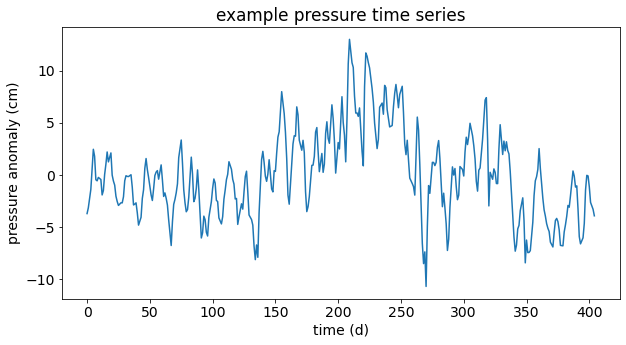

In [60]:
# make demonstrative plot
ampfac = 1/10065/0.01 # Pa to cm seawater
t = np.array(LT01['time'])
p = np.array(LT01['pressure'])

params = {'legend.fontsize': 14, \
          'xtick.labelsize':14, \
          'ytick.labelsize':14, \
          'font.size':14}
plt.rcParams.update(params)

fig1 = plt.figure(figsize=(10, 5))
ax1 = fig1.add_subplot(111)
ax1.plot(t-t[0],(p-np.mean(p))*ampfac)
ax1.set_xlabel('time (d)')
ax1.set_ylabel('pressure anomaly (cm)')
plt.title('example pressure time series')

### Satellite altimetry

Get altimetry data from Copernicus Marine (https://marine.copernicus.eu/)

In [ ]:
# Will not work as written. Need to install the motuclient, replace <EXAMPLE> terms with my values
python -m motuclient --motu https://my.cmems-du.eu/motu-web/Motu --service-id \
    SEALEVEL_GLO_PHY_CLIMATE_L4_REP_OBSERVATIONS_008_057-TDS --product-id \
    dataset-duacs-rep-global-merged-twosat-phy-l4 --longitude-min 0.125 \
    --longitude-max -0.125 --latitude-min -89.875 --latitude-max 89.875 \
    --date-min "2020-06-03 00:00:00" --date-max "2020-06-03 00:00:00" \
    --variable adt --variable err --variable sla --variable ugos --variable ugosa \
    --variable vgos --variable vgosa --out-dir <OUTPUT_DIRECTORY> --out-name \
    <OUTPUT_FILENAME> --user <USERNAME> --pwd <PASSWORD>

Alternatively, load from pre-made netcdf

In [13]:
sshfile = 'data/altimetry.nc'
SSH = nc.Dataset(sshfile)
SSH

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): y(29), x(49), t(385)
    variables(dimensions): float64 latitude(y), float64 longitude(x), float64 time(t), float64 ssh(t,y,x)
    groups: 

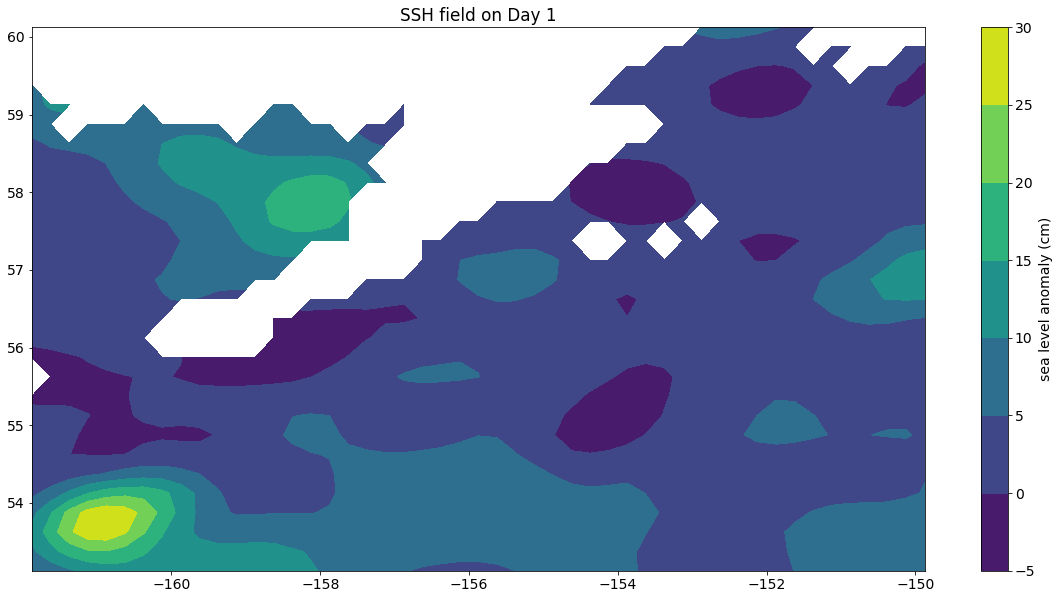

In [59]:
# make demonstrative plot
sla = np.array(SSH['ssh'])*100 # convert from m to cm
ta = np.array(SSH['time'])
x = -(360 - np.array(SSH['longitude']))
y = np.array(SSH['latitude'])
X, Y = np.meshgrid(x, y)

fig2 = plt.figure(figsize=(20, 10))
ax2 = fig2.add_subplot(111)
im = ax2.contourf(X, Y, sla[1,:,:])
cb = fig2.colorbar(im)
plt.title('SSH field on Day 1')
cb.set_label('sea level anomaly (cm)')

### Oceanographic model

Model data not currently publicly available :(
Load from netcdf

In [41]:
modfile1 = 'data/CGOA_p.nc' # bottom pressure
modfile2 = 'data/CGOA_ssh.nc' # sea surface height
modfile3 = 'data/CGOA_T.nc' # bottom temperature
Pm = nc.Dataset(modfile1)
SSHm = nc.Dataset(modfile2)
Tm = nc.Dataset(modfile3)
Tm

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): y(117), x(84), t(384)
    variables(dimensions): float64 latitude(y), float64 longitude(x), float64 depth(y,x), float64 time(t), float64 temperature(t,y,x)
    groups: 

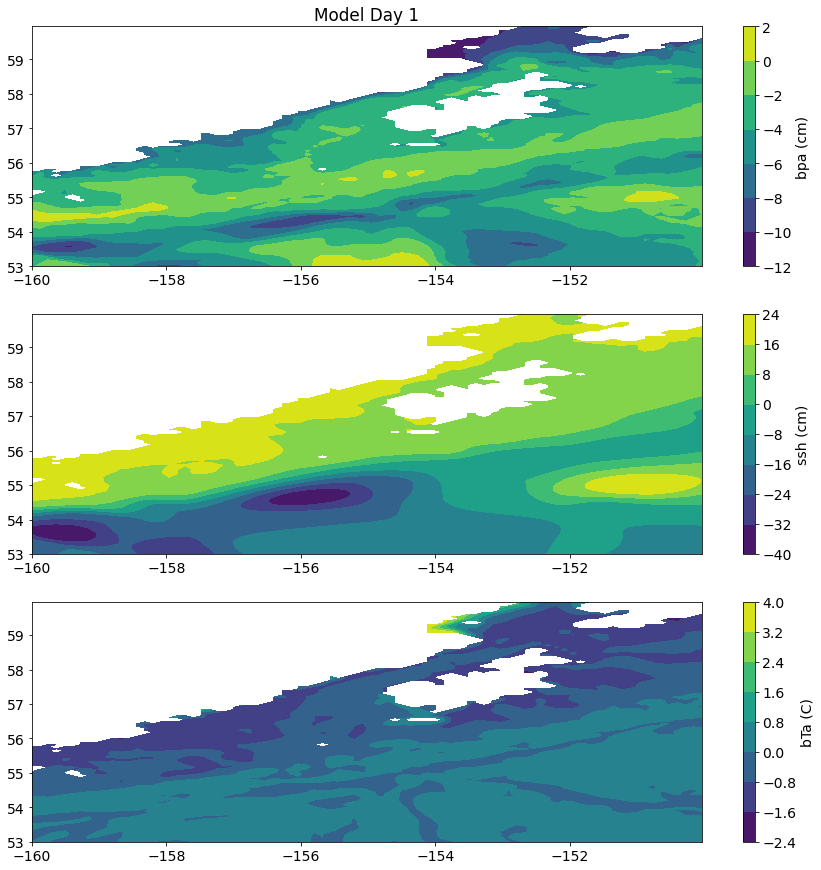

In [49]:
# make demonstrative plots
p_mod = np.array(Pm['pressure'])
ssh_mod = np.array(SSHm['ssh'])
T_mod = np.array(Tm['temperature'])
t_mod = np.array(Pm['time'])
x_mod = np.array(Pm['longitude'])
y_mod = np.array(Pm['latitude'])
Xm, Ym = np.meshgrid(x_mod, y_mod)

pa_mod = np.zeros((384,117,84))
Ta_mod = np.zeros((384,117,84))
for i in range(84):
    for j in range(117):
        pa_mod[:,j,i] = p_mod[:,j,i] - np.mean(p_mod[:,j,i])
        Ta_mod[:,j,i] = T_mod[:,j,i] - np.mean(T_mod[:,j,i])

fig3 = plt.figure(figsize=(15, 15))
ax3a = fig3.add_subplot(311)
im = ax3a.contourf(Xm, Ym, pa_mod[1,:,:]*ampfac)
cb = fig3.colorbar(im)
plt.title('Model Day 1')
cb.set_label('bpa (cm)')
ax3b = fig3.add_subplot(312)
imb = ax3b.contourf(Xm, Ym, ssh_mod[1,:,:]*100)
cbb = fig3.colorbar(imb)
cbb.set_label('ssh (cm)')
ax3c = fig3.add_subplot(313)
imc = ax3c.contourf(Xm, Ym, Ta_mod[1,:,:])
cbc = fig3.colorbar(imc)
cbc.set_label('bTa (C)')

In [64]:
y_mod

array([ 53.  ,  53.06,  53.12,  53.18,  53.24,  53.3 ,  53.36,  53.42,
        53.48,  53.54,  53.6 ,  53.66,  53.72,  53.78,  53.84,  53.9 ,
        53.96,  54.02,  54.08,  54.14,  54.2 ,  54.26,  54.32,  54.38,
        54.44,  54.5 ,  54.56,  54.62,  54.68,  54.74,  54.8 ,  54.86,
        54.92,  54.98,  55.04,  55.1 ,  55.16,  55.22,  55.28,  55.34,
        55.4 ,  55.46,  55.52,  55.58,  55.64,  55.7 ,  55.76,  55.82,
        55.88,  55.94,  56.  ,  56.06,  56.12,  56.18,  56.24,  56.3 ,
        56.36,  56.42,  56.48,  56.54,  56.6 ,  56.66,  56.72,  56.78,
        56.84,  56.9 ,  56.96,  57.02,  57.08,  57.14,  57.2 ,  57.26,
        57.32,  57.38,  57.44,  57.5 ,  57.56,  57.62,  57.68,  57.74,
        57.8 ,  57.86,  57.92,  57.98,  58.04,  58.1 ,  58.16,  58.22,
        58.28,  58.34,  58.4 ,  58.46,  58.52,  58.58,  58.64,  58.7 ,
        58.76,  58.82,  58.88,  58.94,  59.  ,  59.06,  59.12,  59.18,
        59.24,  59.3 ,  59.36,  59.42,  59.48,  59.54,  59.6 ,  59.66,
      

In [57]:
LT01['latitude'][0]

masked_array(data = 56.775555,
             mask = False,
       fill_value = 1e+20)

Text(0.5, 1.0, 'example pressure time series')

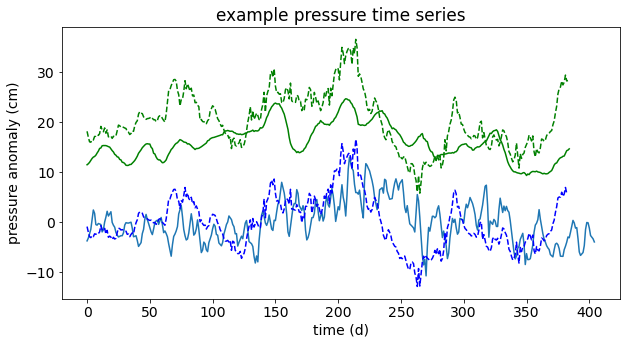

In [71]:
# plot time series on same axes
fig4 = plt.figure(figsize=(10, 5))
ax4 = fig4.add_subplot(111)
ax4.plot(t-t[0],(p-np.mean(p))*ampfac)
ax4.plot(ta-ta[0], sla[:,15,38] + 10, color='green')
ax4.plot(t_mod-t_mod[0], pa_mod[:,63,64]*ampfac, color='blue', linestyle='dashed')
ax4.plot(t_mod-t_mod[0], ssh_mod[:,63,64]*100 + 5, color='green', linestyle='dashed')
ax4.set_xlabel('time (d)')
ax4.set_ylabel('pressure anomaly (cm)')
plt.title('example pressure time series')